In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# Based on: https://gmihaila.github.io/tutorial_notebooks/gpt2_finetune_classification/

In [2]:
import io
import os
import torch
import warnings
from io import StringIO
import pandas as pd
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

# Supress deprecation warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Set seed for reproducibility.
set_seed(4444)

epochs = 4
batch_size = 10
# Max lenght gpt2 => 1024
max_length = None

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name_or_path = '/data/forta/ethereum/model'
tokenizer_name_or_path = '/data/forta/ethereum/tokenizer'

labels_ids = {'malicious': 0, 'normal': 1}
n_labels = len(labels_ids)

In [3]:
class SmartContractOpcodeDataset(Dataset):
  r""" PyTorch Dataset class for loading data. """

  def __init__(self, path, use_tokenizer):
    if not os.path.isdir(path):
      raise ValueError('Invalid `path` variable! Needs to be a directory')
    self.texts = []
    self.labels = []
    # Since the labels are defined by folders with data we loop 
    # through each label.
    for label in ['normal', 'malicious']:
      opcode_path = os.path.join(path, label)
      # Get all files from path.
      files_names = os.listdir(opcode_path)
      # Go through each file and read its content.
      for file_name in tqdm(files_names, desc=f'{label} files'):
        file_path = os.path.join(opcode_path, file_name)
        current_file = io.open(file_path, mode='r', encoding='utf-8')
        for line in current_file:
            # List comprehension to read lines, strip whitespace, and convert to int
            integers = [int(float(num)) for num in line.strip().split('\t')]
            self.texts.append(torch.tensor(integers, dtype=torch.int))
            self.labels.append(label)
    self.n_examples = len(self.labels)

    return

  def __len__(self):
    return self.n_examples

  def __getitem__(self, item):
    return {'text':self.texts[item],
            'label':self.labels[item]}

class Gpt2ClassificationCollator(object):
    r""" Data Collator used for GPT2 in a classificaiton rask. """

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):
        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class.
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [sequence['label'] for sequence in sequences]
        labels = [self.labels_encoder[label] for label in labels]

        # We don't need to use the tokenizer since the data is already in numeric format
        inputs = {'input_ids':torch.stack(texts, dim=0)}
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs

def train(dataloader, optimizer_, scheduler_, device_):
  r""" Train pytorch model on a single pass through the data loader. """
  # Use global variable for model.
  global model
  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0
  # Put the model into training mode.
  model.train()
  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):
    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
    # The documentation for this a bert model function is here: 
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the 
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)
  
  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

def validation(dataloader, device_):
  r""" Validation function to evaluate model performance on a 
  separate set of data. """

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):
    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    # Telling the model not to compute or store gradients, saving memory andbatch.items()
    # speeding up validation
    with torch.no_grad():        
        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        
        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

In [4]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=tokenizer_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token

# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))
# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at /data/forta/ethereum/model and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading configuraiton...
Loading tokenizer...
Loading model...
Model loaded to `cpu`


In [5]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)

print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = SmartContractOpcodeDataset(path='/data/forta/ethereum/text/finetuning/training', 
                               use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print('Dealing with Validation...')
# Create pytorch dataset.
valid_dataset =  SmartContractOpcodeDataset(path='/data/forta/ethereum/text/finetuning/validation', 
                               use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Dealing with Train...


normal files:   0%|          | 0/1 [00:00<?, ?it/s]

malicious files:   0%|          | 0/1 [00:00<?, ?it/s]

Created `train_dataset` with 6163 examples!
Created `train_dataloader` with 617 batches!
Dealing with Validation...


normal files:   0%|          | 0/1 [00:00<?, ?it/s]

malicious files:   0%|          | 0/1 [00:00<?, ?it/s]

Created `valid_dataset` with 1430 examples!
Created `eval_dataloader` with 143 batches!


In [6]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5
                  eps = 1e-8 # default is 1e-8
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data. 
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

Epoch


  0%|          | 0/4 [00:00<?, ?it/s]

Training on batches...


  0%|          | 0/617 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/143 [00:00<?, ?it/s]

  train_loss: 0.19951 - val_loss: 0.17155 - train_acc: 0.93996 - valid_acc: 0.94895
Training on batches...


  0%|          | 0/617 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/143 [00:00<?, ?it/s]

  train_loss: 0.10471 - val_loss: 0.19365 - train_acc: 0.97128 - valid_acc: 0.94965
Training on batches...


  0%|          | 0/617 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



# 

  0%|          | 0/143 [00:00<?, ?it/s]

              precision    recall  f1-score   support

   malicious       0.77      0.83      0.80       127
      normal       0.98      0.98      0.98      1303

    accuracy                           0.96      1430
   macro avg       0.88      0.90      0.89      1430
weighted avg       0.96      0.96      0.96      1430

Normalized confusion matrix


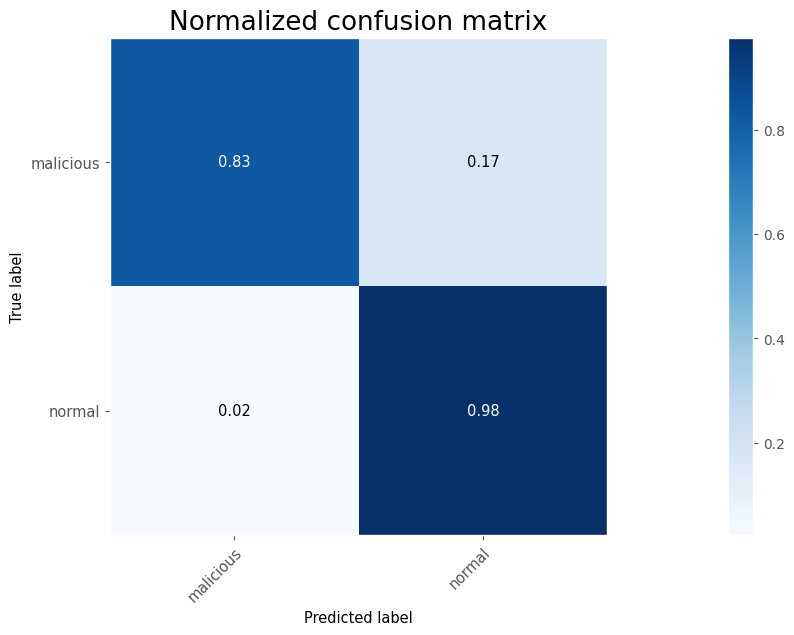

In [7]:
# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()),
                                          target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                      classes=list(labels_ids.keys()), normalize=True, 
                      magnify=0.1,
                      );